In [ ]:
# https://github.com/huggingface/notebooks/blob/master/transformers_doc/quicktour.ipynb

In [1]:
#! pip install transformers datasets

# Getting started on a task with a pipeline
The easiest way to use a pretrained model on a given task is to use pipeline.

In [2]:
from transformers import pipeline

# Transformers provides the following tasks out of the box:

Sentiment analysis: is a text positive or negative?

Text generation (in English): provide a prompt and the model will generate what follows.

Name entity recognition (NER): in an input sentence, label each word with the entity it represents (person, place, etc.)

Question answering: provide the model with some context and a question, extract the answer from the context.

Filling masked text: given a text with masked words (e.g., replaced by [MASK]), fill the blanks.

Summarization: generate a summary of a long text.

Translation: translate a text in another language.

Feature extraction: return a tensor representation of the text.

# Let's see how this work for sentiment analysis 

In [3]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [4]:
classifier('We are very happy to show you the 🤗 Transformers library.')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [5]:
results = classifier(["We are very happy to show you the 🤗 Transformers library.",
           "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.5309


Let's say we want to use another model; for instance, one that has been trained on French data. We can search through the model hub that gathers models pretrained on a lot of data by research labs, but also community models (usually fine-tuned versions of those big models on a specific dataset). Applying the tags "French" and "text-classification" gives back a suggestion "nlptown/bert-base-multilingual-uncased-sentiment". Let's see how we can use it.

You can directly pass the name of the model to use to pipeline:

In [6]:
# classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

This classifier can now deal with texts in English, French, but also Dutch, German, Italian and Spanish! You can also replace that name by a local folder where you have saved a pretrained model (see below). You can also pass a model object and its associated tokenizer.

We will need two classes for this. The first is AutoTokenizer, which we will use to download the tokenizer associated to the model we picked and instantiate it. The second is AutoModelForSequenceClassification (or TFAutoModelForSequenceClassification if you are using TensorFlow), which we will use to download the model itself. Note that if we were using the library on an other task, the class of the model would change. The task summary tutorial summarizes which class is used for which task.

In [7]:
## PYTORCH CODE
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Now, to download the models and tokenizer we found previously, we just have to use the AutoModelForSequenceClassification.from_pretrained method (feel free to replace model_name by any other model from the model hub):

In [8]:
## PYTORCH CODE
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

If you don't find a model that has been pretrained on some data similar to yours, you will need to fine-tune a pretrained model on your data. We provide example scripts to do so. Once you're done, don't forget to share your fine-tuned model on the hub with the community, using this tutorial.

# Under the hood: pretrained models
Let's now see what happens beneath the hood when using those pipelines.

As we saw, the model and tokenizer are created using the from_pretrained method:



In [9]:
## PYTORCH CODE
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Using the tokenizer
We mentioned the tokenizer is responsible for the preprocessing of your texts. First, it will split a given text in words (or part of words, punctuation symbols, etc.) usually called tokens. There are multiple rules that can govern that process (you can learn more about them in the tokenizer summary), which is why we need to instantiate the tokenizer using the name of the model, to make sure we use the same rules as when the model was pretrained.

The second step is to convert those tokens into numbers, to be able to build a tensor out of them and feed them to the model. To do this, the tokenizer has a vocab, which is the part we download when we instantiate it with the from_pretrained method, since we need to use the same vocab as when the model was pretrained.

To apply these steps on a given text, we can just feed it to our tokenizer:

In [11]:
inputs = tokenizer("We are very happy to show you the 🤗 Transformers library.")
print(inputs)

{'input_ids': [101, 2057, 2024, 2200, 3407, 2000, 2265, 2017, 1996, 100, 19081, 3075, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


This returns a dictionary string to list of ints. It contains the ids of the tokens, as mentioned before, but also additional arguments that will be useful to the model. Here for instance, we also have an attention mask that the model will use to have a better understanding of the sequence:

You can pass a list of sentences directly to your tokenizer. If your goal is to send them through your model as a batch, you probably want to pad them all to the same length, truncate them to the maximum length the model can accept and get tensors back. You can specify all of that to the tokenizer:

In [12]:
## PYTORCH CODE
pt_batch = tokenizer(
    ["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."],
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

The padding is automatically applied on the side expected by the model (in this case, on the right), with the padding token the model was pretrained with. The attention mask is also adapted to take the padding into account:

In [14]:
## PYTORCH CODE
for key, value in pt_batch.items():
    print(f"{key}: {value.numpy().tolist()}")

input_ids: [[101, 2057, 2024, 2200, 3407, 2000, 2265, 2017, 1996, 100, 19081, 3075, 1012, 102], [101, 2057, 3246, 2017, 2123, 1005, 1056, 5223, 2009, 1012, 102, 0, 0, 0]]
attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]


# Using the model
Once your input has been preprocessed by the tokenizer, you can send it directly to the model. As we mentioned, it will contain all the relevant information the model needs. If you're using a TensorFlow model, you can pass the dictionary keys directly to tensors, for a PyTorch model, you need to unpack the dictionary by adding **.

In [15]:
## PYTORCH CODE
pt_outputs = pt_model(**pt_batch)

In 🤗 Transformers, all outputs are objects that contain the model's final activations along with other metadata. These objects are described in greater detail here. For now, let's inspect the output ourselves:

In [16]:
## PYTORCH CODE
print(pt_outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-4.0833,  4.3364],
        [ 0.0818, -0.0418]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


####  Notice how the output object has a logits attribute. You can use this to access the model's final activations.

# NOTE: 
All 🤗 Transformers models (PyTorch or TensorFlow) return the activations of the model before the final activation function (like SoftMax) since this final activation function is often fused with the loss.

Let's apply the SoftMax activation to get predictions.

In [17]:
## PYTORCH CODE
from torch import nn
pt_predictions = nn.functional.softmax(pt_outputs.logits, dim=-1)

In [20]:
# We can see we get the numbers from before:

## PYTORCH CODE
print(pt_predictions)

tensor([[2.2043e-04, 9.9978e-01],
        [5.3086e-01, 4.6914e-01]], grad_fn=<SoftmaxBackward0>)


If you provide the model with labels in addition to inputs, the model output object will also contain a loss attribute:



In [21]:
## PYTORCH CODE
import torch
pt_outputs = pt_model(**pt_batch, labels = torch.tensor([1, 0]))
print(pt_outputs)

SequenceClassifierOutput(loss=tensor(0.3167, grad_fn=<NllLossBackward0>), logits=tensor([[-4.0833,  4.3364],
        [ 0.0818, -0.0418]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


Models are standard torch.nn.Module or tf.keras.Model so you can use them in your usual training loop. 🤗 Transformers also provides a Trainer class to help with your training (taking care of things such as distributed training, mixed precision, etc.). 

# NOTE: 
Pytorch model outputs are special dataclasses so that you can get autocompletion for their attributes in an IDE. They also behave like a tuple or a dictionary (e.g., you can index with an integer, a slice or a string) in which case the attributes not set (that have None values) are ignored.

Once your model is fine-tuned, you can save it with its tokenizer in the following way:



In [23]:
save_directory = "Desktop"
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

You can then load this model back using the AutoModel.from_pretrained method by passing the directory name instead of the model name. One cool feature of 🤗 Transformers is that you can easily switch between PyTorch and TensorFlow: any model saved as before can be loaded back either in PyTorch or TensorFlow. If you are loading a saved PyTorch model in a TensorFlow model, use TFAutoModel.from_pretrained.

and if you are loading a saved TensorFlow model in a PyTorch model, you should use the following code:

In [26]:
from transformers import AutoModel
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = AutoModel.from_pretrained(save_directory)

Some weights of the model checkpoint at Desktop were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lastly, you can also ask the model to return all hidden states and all attention weights if you need them:

In [27]:
## PYTORCH CODE
pt_outputs = pt_model(**pt_batch, output_hidden_states=True, output_attentions=True)
all_hidden_states  = pt_outputs.hidden_states 
all_attentions = pt_outputs.attentions

# Accessing the code
The AutoModel and AutoTokenizer classes are just shortcuts that will automatically work with any pretrained model. Behind the scenes, the library has one model class per combination of architecture plus class, so the code is easy to access and tweak if you need to.

In our previous example, the model was called "distilbert-base-uncased-finetuned-sst-2-english", which means it's using the DistilBERT architecture. As AutoModelForSequenceClassification was used, the model automatically created is then a DistilBertForSequenceClassification. You can look at its documentation for all details relevant to that specific model, or browse the source code. This is how you would directly instantiate model and tokenizer without the auto magic:

In [31]:
## PYTORCH CODE
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = DistilBertForSequenceClassification.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Customizing the model
If you want to change how the model itself is built, you can define a custom configuration class. Each architecture comes with its own relevant configuration. For example, DistilBertConfig allows you to specify parameters such as the hidden dimension, dropout rate, etc for DistilBERT. If you do core modifications, like changing the hidden size, you won't be able to use a pretrained model anymore and will need to train from scratch. You would then instantiate the model directly from this configuration.

Below, we load a predefined vocabulary for a tokenizer with the DistilBertTokenizer.from_pretrained method. However, unlike the tokenizer, we wish to initialize the model from scratch. Therefore, we instantiate the model from a configuration instead of using the DistilBertForSequenceClassification.from_pretrained method.

In [32]:
## PYTORCH CODE
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification
config = DistilBertConfig(n_heads=8, dim=512, hidden_dim=4*512)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification(config)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

For something that only changes the head of the model (for instance, the number of labels), you can still use a pretrained model for the body. For instance, let's define a classifier for 10 different labels using a pretrained body. Instead of creating a new configuration with all the default values just to change the number of labels, we can instead pass any argument a configuration would take to the from_pretrained method and it will update the default configuration appropriately:

In [33]:
## PYTORCH CODE
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=10)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

# Summary of the tasks
This page shows the most frequent use-cases when using the library. The models available allow for many different configurations and a great versatility in use-cases. The most simple ones are presented here, showcasing usage for tasks such as question answering, sequence classification, named entity recognition and others.

These examples leverage auto-models, which are classes that will instantiate a model according to a given checkpoint, automatically selecting the correct model architecture. Please check the AutoModel documentation for more information. Feel free to modify the code to be more specific and adapt it to your specific use-case.

In order for a model to perform well on a task, it must be loaded from a checkpoint corresponding to that task. These checkpoints are usually pre-trained on a large corpus of data and fine-tuned on a specific task. This means the following:

Not all models were fine-tuned on all tasks. If you want to fine-tune a model on a specific task, you can leverage one of the run_$TASK.py scripts in the examples directory.
Fine-tuned models were fine-tuned on a specific dataset. This dataset may or may not overlap with your use-case and domain. As mentioned previously, you may leverage the examples scripts to fine-tune your model, or you may create your own training script.
In order to do an inference on a task, several mechanisms are made available by the library:

Pipelines: very easy-to-use abstractions, which require as little as two lines of code.
Direct model use: Less abstractions, but more flexibility and power via a direct access to a tokenizer (PyTorch/TensorFlow) and full inference capacity.
Both approaches are showcased here.

#### NOTE: 
All tasks presented here leverage pre-trained checkpoints that were fine-tuned on specific tasks. Loading a checkpoint that was not fine-tuned on a specific task would load only the base transformer layers and not the additional head that is used for the task, initializing the weights of that head randomly.

This would produce random output.

# Sequence Classification
Sequence classification is the task of classifying sequences according to a given number of classes. An example of sequence classification is the GLUE dataset, which is entirely based on that task. If you would like to fine-tune a model on a GLUE sequence classification task, you may leverage the :prefix_link:*run_glue.py

<examples/pytorch/text-classification/run_glue.py>, :prefix_link:run_tf_glue.py

<examples/tensorflow/text-classification/run_tf_glue.py>, :prefix_link:run_tf_text_classification.py

<examples/tensorflow/text-classification/run_tf_text_classification.py> or :prefix_link:run_xnli.py

<examples/pytorch/text-classification/run_xnli.py>* scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sequence is positive or negative. It leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [37]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")
result = classifier("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = classifier("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it with the weights stored in the checkpoint.

2. Build a sequence from the two sentences, with the correct model-specific separators, token type ids and attention masks (which will be created automatically by the tokenizer).

3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a paraphrase) and 1 (is a paraphrase).

4. Compute the softmax of the result to get probabilities over the classes.

5. Print the results.

In [38]:
## PYTORCH CODE
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
# The tokekenizer will automatically add any model specific separators (i.e. <CLS> and <SEP>) and tokens to the sequence, as well as compute the attention masks.
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


# Extractive Question Answering
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a model on a SQuAD task, you may leverage the run_qa.py and run_tf_squad.py scripts.

Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It leverages a fine-tuned model on SQuAD.

In [44]:
from transformers import pipeline
question_answerer = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/pytorch/question-answering/run_squad.py script.
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the positions of the extracted answer in the text.

In [45]:
result = question_answerer(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = question_answerer(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6177, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5152, start: 147, end: 160


#### Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it with the weights stored in the checkpoint.

2. Define a text and a few questions.

3. Iterate over the questions and build a sequence from the text and the current question, with the correct model-specific separators token type ids and attention masks.

4. Pass this sequence through the model. This outputs a range of scores across the entire sequence tokens (question and text), for both the start and end positions.

5. Compute the softmax of the result to get probabilities over the tokens.

6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.

7. Print the results.

In [46]:
## PYTORCH CODE
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2. 0 and pytorch


# Language Modeling
Language modeling is the task of fitting a model to a corpus, which can be domain specific. All popular transformer-based models are trained using a variant of language modeling, e.g. BERT with masked language modeling, GPT-2 with causal language modeling.

Language modeling can be useful outside of pretraining as well, for example to shift the model distribution to be domain-specific: using a language model trained over a very large corpus, and then fine-tuning it to a news dataset or on scientific papers e.g. LysandreJik/arxiv-nlp.

# Masked Language Modeling
Masked language modeling is the task of masking tokens in a sequence with a masking token, and prompting the model to fill that mask with an appropriate token. This allows the model to attend to both the right context (tokens on the right of the mask) and the left context (tokens on the left of the mask). Such a training creates a strong basis for downstream tasks requiring bi-directional context, such as SQuAD (question answering, see Lewis, Lui, Goyal et al., part 4.2). If you would like to fine-tune a model on a masked language modeling task, you may leverage the :prefix_link:run_mlm.py <examples/pytorch/language-modeling/run_mlm.py> script.

Here is an example of using pipelines to replace a mask from a sequence:

In [47]:
from transformers import pipeline
unmasker = pipeline("fill-mask")

No model was supplied, defaulted to distilroberta-base (https://huggingface.co/distilroberta-base)


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [48]:
from pprint import pprint
pprint(unmasker(f"HuggingFace is creating a {unmasker.tokenizer.mask_token} that the community uses to solve NLP tasks."))

[{'score': 0.17927508056163788,
  'sequence': 'HuggingFace is creating a tool that the community uses to solve '
              'NLP tasks.',
  'token': 3944,
  'token_str': ' tool'},
 {'score': 0.11349443346261978,
  'sequence': 'HuggingFace is creating a framework that the community uses to '
              'solve NLP tasks.',
  'token': 7208,
  'token_str': ' framework'},
 {'score': 0.05243544280529022,
  'sequence': 'HuggingFace is creating a library that the community uses to '
              'solve NLP tasks.',
  'token': 5560,
  'token_str': ' library'},
 {'score': 0.0349353663623333,
  'sequence': 'HuggingFace is creating a database that the community uses to '
              'solve NLP tasks.',
  'token': 8503,
  'token_str': ' database'},
 {'score': 0.028602443635463715,
  'sequence': 'HuggingFace is creating a prototype that the community uses to '
              'solve NLP tasks.',
  'token': 17715,
  'token_str': ' prototype'}]


#### Here is an example of doing masked language modeling using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a DistilBERT model and loads it with the weights stored in the checkpoint.

2. Define a sequence with a masked token, placing the tokenizer.mask_token instead of a word.

3. Encode that sequence into a list of IDs and find the position of the masked token in that list.

4. Retrieve the predictions at the index of the mask token: this tensor has the same size as the vocabulary, and the values are the scores attributed to each token. The model gives higher score to tokens it deems probable in that context.

5. Retrieve the top 5 tokens using the PyTorch topk or TensorFlow top_k methods.

6. Replace the mask token by the tokens and print the results

In [49]:
## PYTORCH CODE
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = AutoModelWithLMHead.from_pretrained("distilbert-base-cased")
sequence = f"Distilled models are smaller than the models they mimic. Using them instead of the large versions would help {tokenizer.mask_token} our carbon footprint."
input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]
token_logits = model(input).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

C:\Users\Naim Cavin\anaconda3\lib\site-packages\transformers\models\auto\modeling_auto.py:694: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

#### This prints five sequences, with the top 5 tokens predicted by the model:



In [50]:
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

Distilled models are smaller than the models they mimic. Using them instead of the large versions would help reduce our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help increase our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help decrease our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help offset our carbon footprint.
Distilled models are smaller than the models they mimic. Using them instead of the large versions would help improve our carbon footprint.


# Causal Language Modeling
Causal language modeling is the task of predicting the token following a sequence of tokens. In this situation, the model only attends to the left context (tokens on the left of the mask). Such a training is particularly interesting for generation tasks. If you would like to fine-tune a model on a causal language modeling task, you may leverage the :prefix_link:run_clm.py <examples/pytorch/language-modeling/run_clm.py> script.

Usually, the next token is predicted by sampling from the logits of the last hidden state the model produces from the input sequence.

Here is an example of using the tokenizer and model and leveraging the PreTrainedModel.top_k_top_p_filtering method to sample the next token following an input sequence of tokens.

In [51]:
## PYTORCH CODE
from transformers import AutoModelWithLMHead, AutoTokenizer, top_k_top_p_filtering
import torch
from torch import nn
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelWithLMHead.from_pretrained("gpt2")
sequence = f"Hugging Face is based in DUMBO, New York City, and"
input_ids = tokenizer.encode(sequence, return_tensors="pt")
# get logits of last hidden state
next_token_logits = model(input_ids).logits[:, -1, :]
# filter
filtered_next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=50, top_p=1.0)
# sample
probs = nn.functional.softmax(filtered_next_token_logits, dim=-1)
next_token = torch.multinomial(probs, num_samples=1)
generated = torch.cat([input_ids, next_token], dim=-1)
resulting_string = tokenizer.decode(generated.tolist()[0])

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

This outputs a (hopefully) coherent next token following the original sequence, which in our case is the word has:



In [52]:
print(resulting_string)

Hugging Face is based in DUMBO, New York City, and features


# Text Generation
In text generation (a.k.a open-ended text generation) the goal is to create a coherent portion of text that is a continuation from the given context. The following example shows how GPT-2 can be used in pipelines to generate text. As a default all models apply Top-K sampling when used in pipelines, as configured in their respective configurations (see gpt-2 config for example).

In [53]:
from transformers import pipeline
text_generator = pipeline("text-generation")
print(text_generator("As far as I am concerned, I will", max_length=50, do_sample=False))

No model was supplied, defaulted to gpt2 (https://huggingface.co/gpt2)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'As far as I am concerned, I will be the first to admit that I am not a fan of the idea of a "free market." I think that the idea of a free market is a bit of a stretch. I think that the idea'}]


Here, the model generates a random text with a total maximal length of 50 tokens from context "As far as I am concerned, I will". Behind the scenes, the pipeline object calls the method PreTrainedModel.generate to generate text. The default arguments for this method can be overridden in the pipeline, as is shown above for the arguments max_length and do_sample.

Below is an example of text generation using XLNet and its tokenizer, which includes calling generate directly:

In [54]:
## PYTORCH CODE
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("xlnet-base-cased")
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
# Padding text helps XLNet with short prompts - proposed by Aman Rusia in https://github.com/rusiaaman/XLNet-gen#methodology
PADDING_TEXT = """In 1991, the remains of Russian Tsar Nicholas II and his family
(except for Alexei and Maria) are discovered.
The voice of Nicholas's young son, Tsarevich Alexei Nikolaevich, narrates the
remainder of the story. 1883 Western Siberia,
a young Grigori Rasputin is asked by his father and a group of men to perform magic.
Rasputin has a vision and denounces one of the men as a horse thief. Although his
father initially slaps him for making such an accusation, Rasputin watches as the
man is chased outside and beaten. Twenty years later, Rasputin sees a vision of
the Virgin Mary, prompting him to become a priest. Rasputin quickly becomes famous,
with people, even a bishop, begging for his blessing. <eod> </s> <eos>"""
prompt = "Today the weather is really nice and I am planning on "
inputs = tokenizer.encode(PADDING_TEXT + prompt, add_special_tokens=False, return_tensors="pt")
prompt_length = len(tokenizer.decode(inputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))
outputs = model.generate(inputs, max_length=250, do_sample=True, top_p=0.95, top_k=60)
generated = prompt + tokenizer.decode(outputs[0])[prompt_length:]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [55]:
print(generated)

Today the weather is really nice and I am planning on anning on going to an incredible event in the future. As I wrote yesterday, I saw this video that we were on Sunday, but today it is beautiful to listen and watch in the heat of the day. It is kind of a pleasure to see other people and watch the scene in motion with you in it. But I still love being a fan of it. I can do


Text generation is currently possible with GPT-2, OpenAi-GPT, CTRL, XLNet, Transfo-XL and Reformer in PyTorch and for most models in Tensorflow as well. As can be seen in the example above XLNet and Transfo-XL often need to be padded to work well. GPT-2 is usually a good choice for open-ended text generation because it was trained on millions of webpages with a causal language modeling objective.

For more information on how to apply different decoding strategies for text generation, please also refer to our text generation blog post here.

# Named Entity Recognition
Named Entity Recognition (NER) is the task of classifying tokens according to a class, for example, identifying a token as a person, an organisation or a location. An example of a named entity recognition dataset is the CoNLL-2003 dataset, which is entirely based on that task. If you would like to fine-tune a model on an NER task, you may leverage the :prefix_link:run_ner.py <examples/pytorch/token-classification/run_ner.py> script.

Here is an example of using pipelines to do named entity recognition, specifically, trying to identify tokens as belonging to one of 9 classes:

O, Outside of a named entity

B-MIS, Beginning of a miscellaneous entity right after another miscellaneous entity

I-MIS, Miscellaneous entity

B-PER, Beginning of a person's name right after another person's name

I-PER, Person's name

B-ORG, Beginning of an organisation right after another organisation

I-ORG, Organisation

B-LOC, Beginning of a location right after another location

I-LOC, Location

It leverages a fine-tuned model on CoNLL-2003, fine-tuned by @stefan-it from dbmdz.

In [56]:
from transformers import pipeline
ner_pipe = pipeline("ner")
sequence = """Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO,
therefore very close to the Manhattan Bridge which is visible from the window."""

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

This outputs a list of all words that have been identified as one of the entities from the 9 classes defined above. Here are the expected results:

Note how the tokens of the sequence "Hugging Face" have been identified as an organisation, and "New York City", "DUMBO" and "Manhattan Bridge" have been identified as locations.

Here is an example of doing named entity recognition, using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it with the weights stored in the checkpoint.

2. Define a sequence with known entities, such as "Hugging Face" as an organisation and "New York City" as a location.

3. Split words into tokens so that they can be mapped to predictions. We use a small hack by, first, completely encoding and decoding the sequence, so that we're left with a string that contains the special tokens.

4. Encode that sequence into IDs (special tokens are added automatically).

5. Retrieve the predictions by passing the input to the model and getting the first output. This results in a distribution over the 9 possible classes for each token. We take the argmax to retrieve the most likely class for each token.

6. Zip together each token with its prediction and print it.

In [57]:
## PYTORCH CODE
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
label_list = [
    "O",       # Outside of a named entity
    "B-MISC",  # Beginning of a miscellaneous entity right after another miscellaneous entity
    "I-MISC",  # Miscellaneous entity
    "B-PER",   # Beginning of a person's name right after another person's name
    "I-PER",   # Person's name
    "B-ORG",   # Beginning of an organisation right after another organisation
    "I-ORG",   # Organisation
    "B-LOC",   # Beginning of a location right after another location
    "I-LOC"    # Location
]
sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
           "close to the Manhattan Bridge."
# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")
outputs = model(inputs).logits
predictions = torch.argmax(outputs, dim=2)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

This outputs a list of each token mapped to its corresponding prediction. Differently from the pipeline, here every token has a prediction as we didn't remove the "0"th class, which means that no particular entity was found on that token.

In the above example, predictions is an integer that corresponds to the predicted class. We can use the model.config.id2label property in order to recover the class name corresponding to the class number, which is illustrated below:

In [58]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

('[CLS]', 'O')
('Hu', 'I-ORG')
('##gging', 'I-ORG')
('Face', 'I-ORG')
('Inc', 'I-ORG')
('.', 'O')
('is', 'O')
('a', 'O')
('company', 'O')
('based', 'O')
('in', 'O')
('New', 'I-LOC')
('York', 'I-LOC')
('City', 'I-LOC')
('.', 'O')
('Its', 'O')
('headquarters', 'O')
('are', 'O')
('in', 'O')
('D', 'I-LOC')
('##UM', 'I-LOC')
('##BO', 'I-LOC')
(',', 'O')
('therefore', 'O')
('very', 'O')
('##c', 'O')
('##lose', 'O')
('to', 'O')
('the', 'O')
('Manhattan', 'I-LOC')
('Bridge', 'I-LOC')
('.', 'O')
('[SEP]', 'O')


# Summarization
Summarization is the task of summarizing a document or an article into a shorter text. If you would like to fine-tune a model on a summarization task, you may leverage the run_summarization.py script.

An example of a summarization dataset is the CNN / Daily Mail dataset, which consists of long news articles and was created for the task of summarization. If you would like to fine-tune a model on a summarization task, various approaches are described in this :prefix_link:document <examples/pytorch/summarization/README.md>.

Here is an example of using the pipelines to do summarization. It leverages a Bart model that was fine-tuned on the CNN / Daily Mail data set.

In [59]:
from transformers import pipeline
summarizer = pipeline("summarization")
ARTICLE = """ New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.
"""

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Because the summarization pipeline depends on the PreTrainedModel.generate() method, we can override the default arguments of PreTrainedModel.generate() directly in the pipeline for max_length and min_length as shown below. This outputs the following summary:

In [60]:
print(summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False))

[{'summary_text': ' Liana Barrientos, 39, is charged with two counts of "offering a false instrument for filing in the first degree" In total, she has been married 10 times, with nine of her marriages occurring between 1999 and 2002 . At one time, she was married to eight men at once, prosecutors say .'}]


Here is an example of doing summarization using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. Summarization is usually done using an encoder-decoder model, such as Bart or T5.
2. Define the article that should be summarized.
3. Add the T5 specific prefix "summarize: ".
4. Use the PreTrainedModel.generate() method to generate the summary.

In [61]:
## PYTORCH CODE
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")
# T5 uses a max_length of 512 so we cut the article to 512 tokens.
inputs = tokenizer.encode("summarize: " + ARTICLE, return_tensors="pt", max_length=512, truncation=True)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [62]:
print(tokenizer.decode(outputs[0]))

<pad> prosecutors say the marriages were part of an immigration scam. if convicted, barrientos faces two criminal counts of "offering a false instrument for filing in the first degree" she has been married 10 times, nine of them between 1999 and 2002.</s>


# Translation
Translation is the task of translating a text from one language to another. If you would like to fine-tune a model on a translation task, you may leverage the run_translation.py script.

An example of a translation dataset is the WMT English to German dataset, which has sentences in English as the input data and the corresponding sentences in German as the target data. If you would like to fine-tune a model on a translation task, various approaches are described in this :prefix_link:*document

<examples/pytorch.translation/README.md>*.

Here is an example of using the pipelines to do translation. It leverages a T5 model that was only pre-trained on a multi-task mixture dataset (including WMT), yet, yielding impressive translation results.

In [63]:
from transformers import pipeline
translator = pipeline("translation_en_to_de")
print(translator("Hugging Face is a technology company based in New York and Paris", max_length=40))

No model was supplied, defaulted to t5-base (https://huggingface.co/t5-base)


[{'translation_text': 'Hugging Face ist ein Technologieunternehmen mit Sitz in New York und Paris.'}]


Because the translation pipeline depends on the PreTrainedModel.generate() method, we can override the default arguments of PreTrainedModel.generate() directly in the pipeline as is shown for max_length above.

Here is an example of doing translation using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. Summarization is usually done using an encoder-decoder model, such as Bart or T5.

2. Define the article that should be summarized.

3. Add the T5 specific prefix "translate English to German: "

4. Use the PreTrainedModel.generate() method to perform the translation.

In [64]:
## PYTORCH CODE
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")
inputs = tokenizer.encode("translate English to German: Hugging Face is a technology company based in New York and Paris", return_tensors="pt")
outputs = model.generate(inputs, max_length=40, num_beams=4, early_stopping=True)

As with the pipeline example, we get the same translation:



In [65]:
print(tokenizer.decode(outputs[0]))

<pad> Hugging Face ist ein Technologieunternehmen mit Sitz in New York und Paris.</s>


# Preprocessing data
In this tutorial, we'll explore how to preprocess your data using 🤗 Transformers. The main tool for this is what we call a tokenizer. You can build one using the tokenizer class associated to the model you would like to use, or directly with the AutoTokenizer class.

As we saw in the quick tour, the tokenizer will first split a given text in words (or part of words, punctuation symbols, etc.) usually called tokens. Then it will convert those tokens into numbers, to be able to build a tensor out of them and feed them to the model. It will also add any additional inputs the model might expect to work properly.

NOTE: If you plan on using a pretrained model, it's important to use the associated pretrained tokenizer: it will split the text you give it in tokens the same way for the pretraining corpus, and it will use the same correspondence token to index (that we usually call a vocab) as during pretraining.

To automatically download the vocab used during pretraining or fine-tuning a given model, you can use the AutoTokenizer.from_pretrained method:

#### Base use
A PreTrainedTokenizer has many methods, but the only one you need to remember for preprocessing is its __call__: you just need to feed your sentence to your tokenizer object.

In [66]:
encoded_input = tokenizer("Hello, I'm a single sentence!")
print(encoded_input)

{'input_ids': [8774, 6, 27, 31, 51, 3, 9, 712, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


This returns a dictionary string to list of ints. The input_ids are the indices corresponding to each token in our sentence. We will see below what the attention_mask is used for and in the next section the goal of token_type_ids.

The tokenizer can decode a list of token ids in a proper sentence:

In [67]:
tokenizer.decode(encoded_input["input_ids"])

"Hello, I'm a single sentence!</s>"

As you can see, the tokenizer automatically added some special tokens that the model expects. Not all models need special tokens; for instance, if we had used gpt2-medium instead of bert-base-cased to create our tokenizer, we would have seen the same sentence as the original one here. You can disable this behavior (which is only advised if you have added those special tokens yourself) by passing add_special_tokens=False.

If you have several sentences you want to process, you can do this efficiently by sending them as a list to the tokenizer:

In [68]:
batch_sentences = ["Hello I'm a single sentence",
                   "And another sentence",
                   "And the very very last one"]
encoded_inputs = tokenizer(batch_sentences)
print(encoded_inputs)

{'input_ids': [[8774, 27, 31, 51, 3, 9, 712, 7142, 1], [275, 430, 7142, 1], [275, 8, 182, 182, 336, 80, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}


We get back a dictionary once again, this time with values being lists of lists of ints.

If the purpose of sending several sentences at a time to the tokenizer is to build a batch to feed the model, you will probably want:

1. To pad each sentence to the maximum length there is in your batch.

2. To truncate each sentence to the maximum length the model can accept (if applicable).

3. To return tensors.

You can do all of this by using the following options when feeding your list of sentences to the tokenizer:

In [69]:
## PYTORCH CODE
batch = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(batch)

{'input_ids': tensor([[8774,   27,   31,   51,    3,    9,  712, 7142,    1],
        [ 275,  430, 7142,    1,    0,    0,    0,    0,    0],
        [ 275,    8,  182,  182,  336,   80,    1,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0]])}


It returns a dictionary with string keys and tensor values. We can now see what the attention_mask is all about: it points out which tokens the model should pay attention to and which ones it should not (because they represent padding in this case).

Note that if your model does not have a maximum length associated to it, the command above will throw a warning. You can safely ignore it. You can also pass verbose=False to stop the tokenizer from throwing those kinds of warnings.

# Preprocessing pairs of sentences

Sometimes you need to feed a pair of sentences to your model. For instance, if you want to classify if two sentences in a pair are similar, or for question-answering models, which take a context and a question. For BERT models, the input is then represented like this:
- [CLS] Sequence A [SEP] Sequence B [SEP]

You can encode a ***pair of sentences*** in the format expected by your model ***by supplying the two sentences as two arguments*** (***not a list since a list of two sentences will be interpreted as a batch of two single sentences, as we saw before***). This will once again return a dict string to list of ints:

In [70]:
encoded_input = tokenizer("How old are you?", "I'm 6 years old")
print(encoded_input)

{'input_ids': [571, 625, 33, 25, 58, 1, 27, 31, 51, 431, 203, 625, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


If we decode the token ids we obtained, we will see that the special tokens have been properly added.



In [71]:
tokenizer.decode(encoded_input["input_ids"])

"How old are you?</s> I'm 6 years old</s>"

If you have a list of pairs of sequences you want to process, you should feed them as two lists to your tokenizer: the list of first sentences and the list of second sentences:



In [74]:
batch_sentences = ["Hello I'm a single sentence",
                   "And another sentence",
                   "And the very very last one"]
batch_of_second_sentences = ["I'm a sentence that goes with the first sentence",
                             "And I should be encoded with the second sentence",
                             "And I go with the very last one"]
encoded_inputs = tokenizer(batch_sentences, batch_of_second_sentences)
print(encoded_inputs)

{'input_ids': [[8774, 27, 31, 51, 3, 9, 712, 7142, 1, 27, 31, 51, 3, 9, 7142, 24, 1550, 28, 8, 166, 7142, 1], [275, 430, 7142, 1, 275, 27, 225, 36, 23734, 26, 28, 8, 511, 7142, 1], [275, 8, 182, 182, 336, 80, 1, 275, 27, 281, 28, 8, 182, 336, 80, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


As we can see, it returns a dictionary where each value is a list of lists of ints.



To double-check what is fed to the model, we can decode each list in input_ids one by one:



In [76]:
for ids in encoded_inputs["input_ids"]:
    print(tokenizer.decode(ids))

Hello I'm a single sentence</s> I'm a sentence that goes with the first sentence</s>
And another sentence</s> And I should be encoded with the second sentence</s>
And the very very last one</s> And I go with the very last one</s>


Once again, you can automatically pad your inputs to the maximum sentence length in the batch, truncate to the maximum length the model can accept and return tensors directly with the following:

In [77]:
## PYTORCH CODE
batch = tokenizer(batch_sentences, batch_of_second_sentences, padding=True, truncation=True, return_tensors="pt")

In [78]:
print(batch)

{'input_ids': tensor([[ 8774,    27,    31,    51,     3,     9,   712,  7142,     1,    27,
            31,    51,     3,     9,  7142,    24,  1550,    28,     8,   166,
          7142,     1],
        [  275,   430,  7142,     1,   275,    27,   225,    36, 23734,    26,
            28,     8,   511,  7142,     1,     0,     0,     0,     0,     0,
             0,     0],
        [  275,     8,   182,   182,   336,    80,     1,   275,    27,   281,
            28,     8,   182,   336,    80,     1,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


# Everything you always wanted to know about padding and truncation
We have seen the commands that will work for most cases (pad your batch to the length of the maximum sentence and truncate to the maximum length the mode can accept). However, the API supports more strategies if you need them. The three arguments you need to know for this are padding, truncation and max_length.

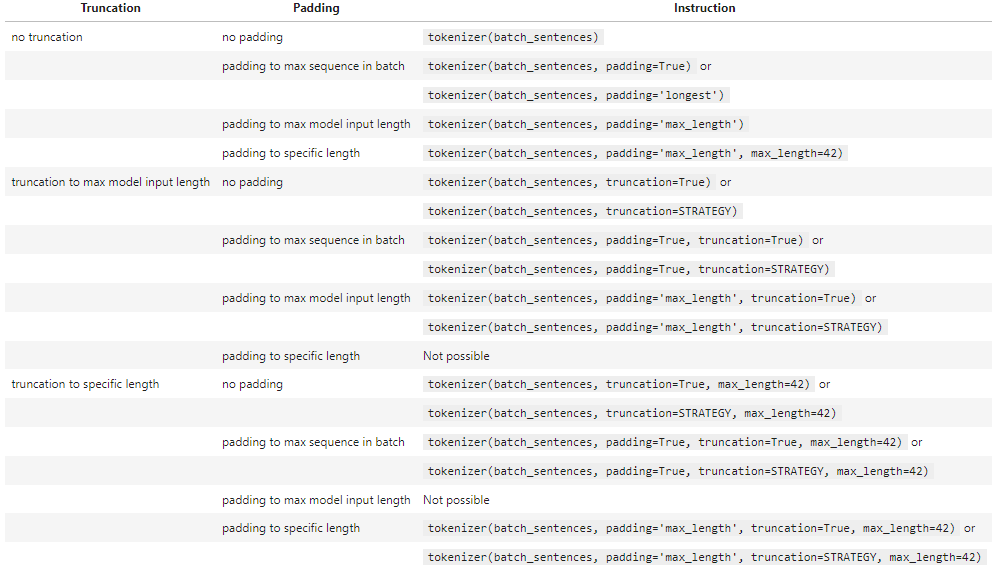

# Fine-tuning a pretrained model
In this tutorial, we will show you how to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. In PyTorch, there is no generic training loop so the 🤗 Transformers library provides an API with the class Trainer to let you fine-tune or train a model from scratch easily. Then we will show you how to alternatively write the whole training loop in PyTorch.

Before we can fine-tune a model, we need a dataset. In this tutorial, we will show you how to fine-tune BERT on the IMDB dataset: the task is to classify whether movie reviews are positive or negative. For examples of other tasks, refer to the additional-resources section!

# Preparing the datasets
We will use the 🤗 Datasets library to download and preprocess the IMDB datasets. We will go over this part pretty quickly. Since the focus of this tutorial is on training, you should refer to the 🤗 Datasets documentation or the preprocessing tutorial for more information.

First, we can use the load_dataset function to download and cache the dataset:

In [103]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

Reusing dataset imdb (C:\Users\Naim Cavin\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [85]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

This works like the from_pretrained method we saw for the models and tokenizers (except the cache directory is ~/.cache/huggingface/dataset by default).

The raw_datasets object is a dictionary with three keys: "train", "test" and "unsupervised" (which correspond to the three splits of that dataset). We will use the "train" split for training and the "test" split for validation.

To preprocess our data, we will need a tokenizer:

In [104]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at C:\Users\Naim Cavin/.cache\huggingface\transformers\a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at C:\

As we saw in preprocessing, we can prepare the text inputs for the model with the following command (this is an example, not a command you can execute):

In [82]:
#FOR EXAMPLE: inputs = tokenizer(sentences, padding="max_length", truncation=True)


This will make all the samples have the maximum length the model can accept (here 512), either by padding or truncating them.

However, we can instead apply these preprocessing steps to all the splits of our dataset at once by using the ***map*** method:

In [105]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\Naim Cavin\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a\cache-97a9b41f0f819498.arrow


  0%|          | 0/25 [00:00<?, ?ba/s]

Loading cached processed dataset at C:\Users\Naim Cavin\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a\cache-d9199123f4034b0b.arrow


Next we will generate a small subset of the training and validation set, to enable faster training:

In [106]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000)) 
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000)) 
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

Loading cached shuffled indices for dataset at C:\Users\Naim Cavin\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a\cache-bbe2e20f27131cb8.arrow


In all the examples below, we will always use small_train_dataset and small_eval_dataset. Just replace them by their full equivalent to train or evaluate on the full dataset.

# Fine-tuning in PyTorch with the Trainer API

Since PyTorch does not provide a training loop, the 🤗 Transformers library provides a ***Trainer*** API that is optimized for 🤗 Transformers models, with a wide range of training options and with built-in features like logging, gradient accumulation, and mixed precision.

First, let's define our model:

In [107]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at C:\Users\Naim Cavin/.cache\huggingface\transformers\a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin f

This will issue a warning about some of the pretrained weights not being used and some weights being randomly initialized. That's because we are throwing away the pretraining head of the BERT model to replace it with a classification head which is randomly initialized. We will fine-tune this model on our task, transferring the knowledge of the pretrained model to it (which is why doing ***this is called transfer learning***).

Then, to define our ***Trainer***, we will need to instantiate a ***TrainingArguments***. This class contains all the hyperparameters we can tune for the ***Trainer*** or the flags to activate the different training options it supports. Let's begin by using all the defaults, the only thing we then have to provide is a directory in which the checkpoints will be saved:

In [108]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [110]:
training_args = TrainingArguments("test_trainer",per_device_eval_batch_size=4,
per_device_train_batch_size=4)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [111]:
print(training_args)

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=False,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=test_trainer\runs\Nov20_21-18-09_MSI,
logging_first_step=False,
logging_nan_inf_filter=True,
logging_steps=50

Then we can instantiate a ***Trainer*** like this:



In [112]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset)

To fine-tune our model, we just need to call



we will want to use the GPU if we have access to one (otherwise training might take several hours instead of a couple of minutes). To do this, we define a device we will put our model and our batches on.

In [113]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [114]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 750


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

which will start a training that you can follow with a progress bar, which should take a couple of minutes to complete (as long as you have access to a GPU). It won't actually tell you anything useful about how well (or badly) your model is performing however as by default, there is no evaluation during training, and we didn't tell the Trainer to compute any metrics. Let's have a look on how to do that now!

To have the ***Trainer*** compute and report metrics, we need to give it a ***compute_metrics*** function that takes predictions and labels (grouped in a namedtuple called EvalPrediction) and return a dictionary with string items (the metric names) and float values (the metric values).

The 🤗 Datasets library provides an easy way to get the common metrics used in NLP with the ***load_metric*** function. here we simply use accuracy. Then we define the ***compute_metrics*** function that just convert logits to predictions (remember that all 🤗 Transformers models return the logits) and feed them to compute method of this metric.

In [115]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

The compute function needs to receive a tuple (with logits and labels) and has to return a dictionary with string keys (the name of the metric) and float values. It will be called at the end of each evaluation phase on the whole arrays of predictions/labels.

To check if this works on practice, let's create a new ***Trainer*** with our fine-tuned model:

In [116]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


{'eval_loss': 0.7652339339256287,
 'eval_accuracy': 0.512,
 'eval_runtime': 131.9164,
 'eval_samples_per_second': 7.581,
 'eval_steps_per_second': 1.895}

which showed an ***accuracy of 51.5%*** in our case. But I decresed the num_batch size from 8 to 4.

If you want to fine-tune your model and regularly report the evaluation metrics (for instance at the end of each epoch), here is how you should define your training arguments:

In [117]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


# Fine-tuning in native PyTorch
RAW HTML:

You might need to restart your notebook at this stage to free some memory, or excute the following code:

In [ ]:
del model
del pytorch_model
del trainer
torch.cuda.empty_cache()

Let's now see how to achieve the same results as in trainer section in PyTorch. First we need to define the dataloaders, which we will use to iterate over batches. We just need to apply a bit of post-processing to our tokenized_datasets before doing that to:

1. remove the columns corresponding to values the model does not expect (here the "text" column)

2. rename the column "label" to "labels" (because the model expect the argument to be named labels)

3. set the format of the datasets so they return PyTorch Tensors instead of lists.

Our tokenized_datasets has one method for each of those steps:

In [119]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Now that this is done, we can easily define our dataloaders:

In [120]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

Next, we define our model:

In [121]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at C:\Users\Naim Cavin/.cache\huggingface\transformers\a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin f

We are almost ready to write our training loop, the only two things are missing are an optimizer and a learning rate scheduler. The default optimizer used by the ***Trainer is AdamW***

In [122]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

Finally, the learning rate scheduler used by default it just a linear decay form the maximum value (5e-5 here) to 0:

In [123]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

One last thing, we will want to use the GPU if we have access to one (otherwise training might take several hours instead of a couple of minutes). To do this, we define a device we will put our model and our batches on.

In [124]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We now are ready to train! To get some sense of when it will be finished, we add a progress bar over our number of training steps, using the tqdm library.



In [125]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/375 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 6.00 GiB total capacity; 4.69 GiB already allocated; 0 bytes free; 4.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Note that if you are used to freezing the body of your pretrained model (like in computer vision) the above may seem a bit strange, as we are directly fine-tuning the whole model without taking any precaution. It actually works better this way for Transformers model (so this is not an oversight on our side). If you're not familiar with what "freezing the body" of the model means, forget you read this paragraph.

Now to check the results, we need to write the evaluation loop. Like in the trainer section we will use a metric from the datasets library. Here we accumulate the predictions at each batch before computing the final result when the loop is finished.

In [126]:
metric= load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 6.00 GiB total capacity; 4.72 GiB already allocated; 0 bytes free; 4.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Summary of the tokenizers
On this page, we will have a closer look at tokenization.

As we saw in the preprocessing tutorial, tokenizing a text is splitting it into words or subwords, which then are converted to ids through a look-up table. Converting words or subwords to ids is straightforward, so in this summary, we will focus on splitting a text into words or subwords (i.e. tokenizing a text). More specifically, ***we will look at the three main types of tokenizers used in 🤗 Transformers: Byte-Pair Encoding (BPE), WordPiece, and SentencePiece***, and show examples of which tokenizer type is used by which model.

Note that on each model page, you can look at the documentation of the associated tokenizer to know which tokenizer type was used by the pretrained model. For instance, if we look at ***BertTokenizer, we can see that the model uses WordPiece***.